# Backtesting Attemp 4

### Importing Packages

In [1]:
import pandas as pd
import numpy as np
from math import floor
from datetime import timedelta
import matplotlib.pyplot as plt
from Backtesting_Class import Backtesting_Strategy

### Definning variable

In [2]:
exit_target_sell = False
exit_range_sell = False
exit_hour_sell = False
exit_target_buy = False
exit_range_buy = False
exit_hour_buy = False

In [3]:
instrument = 'UNH'
hora_ini = '09:30:00'
hora_fin = '16:00:00'
client = 100
target = 1.27
tempo = 5
num_bars = 1
tempo_h = 1/12
num_bars_h = int((num_bars*tempo)/tempo_h)

account = 20000
risk = 0.01
profit_buy_pos = 0
profit_sell_pos = 0
profit_buy_neg = 0
profit_sell_neg = 0
exit_buy = 0
exit_sell = 0
total_0 = []

In [4]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '#'):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

### Download Data

In [5]:
historical = pd.read_csv('UNH_5secs.csv',parse_dates=['date'],index_col='date')

### Setting the initial and final date to get days of evaluation

In [6]:
initial_date = '2018/06/08'
final_date = '2019/06/05'

delta = (pd.to_datetime(final_date) - pd.to_datetime(initial_date)).days + 1
print('Number of Evaluation days: ', delta)

Number of Evaluation days:  363


In [7]:
dates = [str((pd.to_datetime(initial_date) + timedelta(days=x)).strftime("%Y/%m/%d")) for x in range(delta)]

In [8]:
total_0 = pd.DataFrame(total_0)

### Main Code to calculate the backtesting results

In [9]:
for i in range(delta):    
    #Getting date
    date = dates[i]

    #Getting the historical piece of data to evaluate
    hist = historical.loc[date,:]

    #Getting the max and mix from historical data. Calculating lots and target
    if (hist.empty == False):
        maximum = hist.high.rolling(num_bars_h).max()[num_bars_h-1]
        minimum = hist.low.rolling(num_bars_h).min()[num_bars_h-1]
        range_tam = round(maximum - minimum,2)
        target = 1.27
        lots = floor((account*risk)/(maximum-minimum)) 
    else:
        maximum = minimum = 0
        range_tam = target = lots = 0
        max_high = min_low = 0
        exit_buy = exit_sell = 0
        calc_sell = calc_buy = False

    #When to buy and sell
    hist['in_buy'] = hist['high'] > maximum
    hist['in_sell'] = hist['low'] < minimum

    if (hist.in_sell.sum() > 0):
        calc_sell = True
        price_sell = round(minimum - 0.02,2)
        in_sell_bar = list(hist['in_sell'])
        in_sell_bar = in_sell_bar.index(True)
        highs_sell = hist.iloc[in_sell_bar:,1]
        lows_sell = hist.iloc[in_sell_bar:,2]
    else:
        calc_sell = False
        price_sell = 0

    if (hist.in_buy.sum() > 0):
        calc_buy = True
        price_buy = round(maximum + 0.02,2)
        in_buy_bar = list(hist['in_buy'])
        in_buy_bar = in_buy_bar.index(True)
        highs_buy = hist.iloc[in_buy_bar:,1]
        lows_buy = hist.iloc[in_buy_bar:,2]
    else:
        calc_buy = False
        price_buy = 0

    #Determining when to exit
    ##sells
    if (calc_sell == True):    
        for k in range(len(lows_sell)):
            if (k == 0):
                new_high_sells = highs_sell[k]
                new_low_sells = lows_sell[k]
            if (k > 0):
                if (highs_sell[k] > new_high_sells):
                    new_high_sells = highs_sell[k]
                if (lows_sell[k] < new_low_sells):
                    new_low_sells = lows_sell[k]

            profit_sell_pos = round(price_sell - new_low_sells ,2)
            profit_sell_neg = round(price_sell - new_high_sells , 2)
            if (profit_sell_neg < -range_tam ):
                profit_sell_neg = -range_tam

            if (profit_sell_pos > target):
                exit_target_sell = True
                exit_sell = target
            if (exit_target_sell == False) and (new_high_sells > maximum):
                exit_range_sell = True
                exit_sell = round(price_sell - maximum,2)
            if (exit_target_sell == False) and (exit_range_sell == False) and (k == len(lows_sell)-1):
                exit_hour_sell = True
                exit_sell = round(price_sell - hist.iloc[-1,3],2)
    else:
        exit_sell = 0
        profit_sell_pos = 0
        profit_sell_neg = 0

    ##buys
    if(calc_buy == True):    
        for j in range(len(highs_buy)):
            if (j == 0):
                new_high_buys = highs_buy[j]
                new_low_buys = lows_buy[j]
            if(j > 0):
                if (highs_buy[j] > new_high_buys):
                    new_high_buys = highs_buy[j]
                if(lows_buy[j] < new_low_buys):
                    new_low_buys = lows_buy[j]

            profit_buy_pos = round(new_high_buys - price_buy ,2)
            profit_buy_neg = round(new_low_buys - price_buy, 2)
            if (profit_buy_neg < -range_tam ):
                profit_buy_neg = -range_tam

            if (profit_buy_pos > target):
                exit_target_buy = True
                exit_buy = target
            if (exit_target_buy == False) and (new_low_buys < minimum):
                exit_range_buy = True
                exit_buy = round(minimum - price_buy,2)
            if (exit_target_buy == False) and (exit_range_buy == False) and (j == len(highs_buy)-1):
                exit_hour_buy = True
                exit_buy = round(hist.iloc[-1,3] - price_buy,2)
    else:
        exit_buy = 0
        profit_buy_pos = 0
        profit_buy_neg = 0

    #Getting results
    results = [date, exit_buy, exit_sell, profit_buy_pos, profit_sell_pos,
               profit_buy_neg, profit_sell_neg, lots]
    results = pd.DataFrame(results).T.set_index(0)

    #Appending results
    total_0 = pd.concat([total_0,results])

    #restart variables in each iteration
    profit_buy_pos = profit_sell_pos = 0
    profit_buy_neg = profit_sell_neg = 0
    exit_buy = exit_sell = 0
    exit_target_sell = exit_range_sell = False
    exit_hour_sell = exit_target_buy = False
    exit_range_buy = exit_hour_buy = False
    calc_buy = calc_sell = False
    
    printProgressBar(i + 1, delta   , prefix = 'Progress:', suffix = 'Complete', length = 50)

Progress: |##################################################| 100.0% Complete


In [12]:
total_0.index.names = ['date']
total_0.columns = ['final profit buy', 'final profit sell', 
                 'max profit buy', 'max profit sell', 
                 'min profit buy', 'min profit sell', 'lots']

In [13]:
total = total_0

In [14]:
#total = pd.read_excel('total_0.xlsx').set_index('date')

### Profit by day

In [15]:
total['profit usd'] = (total['final profit buy'] + total['final profit sell']) * total['lots']

### Acumulated Profit

In [16]:
total['accumulated profit'] = total['profit usd'].cumsum() + account

In [17]:
total['max profit'] = total['accumulated profit'].cummax()

### Instantiating Backtesting class

In [18]:
back = Backtesting_Strategy(total)

### Backtesting Results

### 1. Total Profit (USD)

In [19]:
total_profit_usd = back.final_profit_usd()
print('total profit (USD): ', total_profit_usd)

total profit (USD):  17587.36


#### profit in ticks (mean)

In [20]:
profit_buy_mean = round(((total['max profit buy']).loc[(total['max profit buy']) != 0]).mean(),2)
print('profit buy mean(ticks): ',profit_buy_mean)

profit buy mean(ticks):  1.84


In [21]:
profit_sell_mean = round(((total['max profit sell']).loc[(total['max profit sell']) != 0]).mean(),2)
print('profit sell mean(ticks): ',profit_sell_mean)

profit sell mean(ticks):  2.54


In [22]:
profit_mean = (profit_buy_mean + profit_sell_mean)/2
print('profit mean (ticks): ', profit_mean)

profit mean (ticks):  2.19


### 2. Total commissions (USD)

In [23]:
total_commissions = back.total_commissions()
print('total commissions (USD): ', total_commissions)

total commissions (USD):  797.36


### 3. Net profit

In [24]:
net_profit = total_profit_usd - total_commissions
print('net profit (USD): ', net_profit)

net profit (USD):  16790.0


### 4. Gross Profit and Gross Loss (USD)

In [25]:
gross_profit, gross_loss = back.gross_profit_and_loss()
print('gross profit(USD): ', gross_profit, ' gross loss (USD): ',gross_loss)

gross profit(USD):  41740.5  gross loss (USD):  -24153.14


### 5. Profit Factor

In [26]:
profit_factor = round(abs(gross_profit/gross_loss),2)
print('profit factor: ', profit_factor)

profit factor:  1.73


### 6. Maximal Drawdown

In [27]:
max_drawdown, max_draw_date = back.max_drawdown()
print('maximal drawdown(usd): ', max_drawdown, ' date: ', max_draw_date)

maximal drawdown(usd):  1752.25  date:  2018/08/13


### 7. Relative Drawdown

In [28]:
relative_drawdown = max_drawdown/account
print('Relative drawdown: ', round(relative_drawdown*100,2),'%')

Relative drawdown:  8.76 %


### 8. Absolute Drawdown

In [29]:
absolute_drawdown = back.absolute_drawdown(account)
print('Absolute Drawdown(usd):', absolute_drawdown)

Absolute Drawdown(usd): 0


### 9. Maximal Drawdown Period and date

In [30]:
max_dd_days, dates_max_dd = back.max_drawdown_date(account)
print('Max. number of days in DD: ', max_dd_days, ', between days: ', dates_max_dd)

Max. number of days in DD:  95 , between days:  ['2018/06/26', '2018/09/28']


### 10. Trades Info

#### 10.1. Total transactions

In [31]:
total_trades, total_positive, total_negative, percent_total = back.transactions_info('total')
print('total trades: ', total_trades, ' positive trades: ',total_positive, ' negative trades: ', total_negative,
      '\nTotal Percent profitable: ', round(percent_total*100,2),'%')

total trades:  375  positive trades:  236  negative trades:  139 
Total Percent profitable:  62.93 %


#### 10.2. Short transactions

In [32]:
short_trades, positive_shorts, negative_shorts, percent_shorts = back.transactions_info('shorts')
print('total sell trades: ', short_trades, ' positive shorts: ',positive_shorts, ' negative shorts: ',negative_shorts,
      '\nPercent profitable shorts: ', round(percent_shorts*100,2),'%')

total sell trades:  191  positive shorts:  120  negative shorts:  71 
Percent profitable shorts:  62.83 %


#### 10.3. Long transactions

In [33]:
long_trades, positive_longs, negative_longs, percent_longs = back.transactions_info('longs')
print('total buy trades: ', long_trades, ' positive longs: ',positive_longs,  ' negative longs: ',negative_longs,
      '\nPercent profitable longs: ', round(percent_longs*100,2),'%')

total buy trades:  184  positive longs:  116  negative longs:  68 
Percent profitable longs:  63.04 %


### 11. Expected Payoff

In [34]:
expected_payoff = round((total_profit_usd - total_commissions) / total_trades,2)
print('Expected Payoff: ', expected_payoff)

Expected Payoff:  44.77


### 12. Greater Transactions

#### 12.1. Profitable

In [35]:
greater_prof = back.greater_transactions('profitable')
print('Greater Profitable transaction: ' , greater_prof)

Greater Profitable transaction:  1209.04


#### 12.1. Non Profitable

In [36]:
greater_non_prof = back.greater_transactions('non profitable')
print('Greater non Profitable transaction: ' , greater_non_prof)

Greater non Profitable transaction:  -209.3


### 13. Average Transactions

#### 13.1. Profitable

In [37]:
average_prof = back.average_transaction('profitable')
print('Average profitable transaction: ', average_prof)

Average profitable transaction:  176.87


#### 13.2. Non Profitable

In [38]:
average_non_prof = back.average_transaction('non profitable')
print('Average non profitable transaction: ', average_non_prof)

Average non profitable transaction:  -173.76


### Final Metrics

In [39]:
final_metrics = {}
final_metrics = {'Initial Account (usd)': account, 'Total profit (usd)': total_profit_usd, 'Total Commissions (usd)': total_commissions, 
                 'Net Profit (usd)': net_profit, 'Gross Profit (usd)': gross_profit, 'Gross Loss (usd)': gross_loss, 
                 'Profit Factor': profit_factor, 'Maximal Drawdown (usd)': max_drawdown, 'Maximal Drawdown Date': max_draw_date,
                 'Relative Drawdown (%)': round(relative_drawdown*100,2), 'Absolute Drawdown (usd)': absolute_drawdown,  
                 'Maximal period in Drawdown (days)': max_dd_days, 'Dates of max. DD period': str(dates_max_dd), 
                 'Total Transactions': total_trades, 'Winning Trades': total_positive, 'Winning Trades (%)': round(percent_total*100,2),
                 'Losing Trades': total_negative, 'Losing Trades (%)': round(100-(percent_total*100),2),
                 'Short Positions': short_trades, 'Winning Shorts': positive_shorts, 'Winning Shorts (%)': round(percent_shorts*100,2),
                 'Losing Shorts': negative_shorts, 'Losing Shorts(%)': round(100-(percent_shorts*100),2),
                 'Long Positions': long_trades, 'Winning Longs': positive_longs, 'Winning Longs (%)': round(percent_longs*100,2),
                 'Losing Longs:': negative_longs, 'Losing Longs(%)': round(100-(percent_longs*100),2),
                 'Expected Payoff (usd)': expected_payoff,
                 'Greater Profitable Transaction (usd)': greater_prof, 'Greater non Profitable Transaction (usd)': greater_non_prof,
                 'Profitable Transaction Average (usd)': average_prof, 'Non Profitable Transaction Average (usd)': average_non_prof}

In [40]:
final_metrics = pd.DataFrame(final_metrics, index = [0]).T
final_metrics.index.names = ['Metric']
final_metrics.columns = ['Values']
final_metrics

,Values
Metric,
Initial Account (usd),20000
Total profit (usd),17587.4
Total Commissions (usd),797.36
Net Profit (usd),16790
Gross Profit (usd),41740.5
Gross Loss (usd),-24153.1
Profit Factor,1.73
Maximal Drawdown (usd),1752.25
Maximal Drawdown Date,2018/08/13


### Saving Results

In [41]:
final_metrics.to_excel(instrument+'_'+str(tempo)+'Min.xlsx')

In [42]:
total.to_excel('total_'+instrument+'_'+str(tempo)+'Min.xlsx')

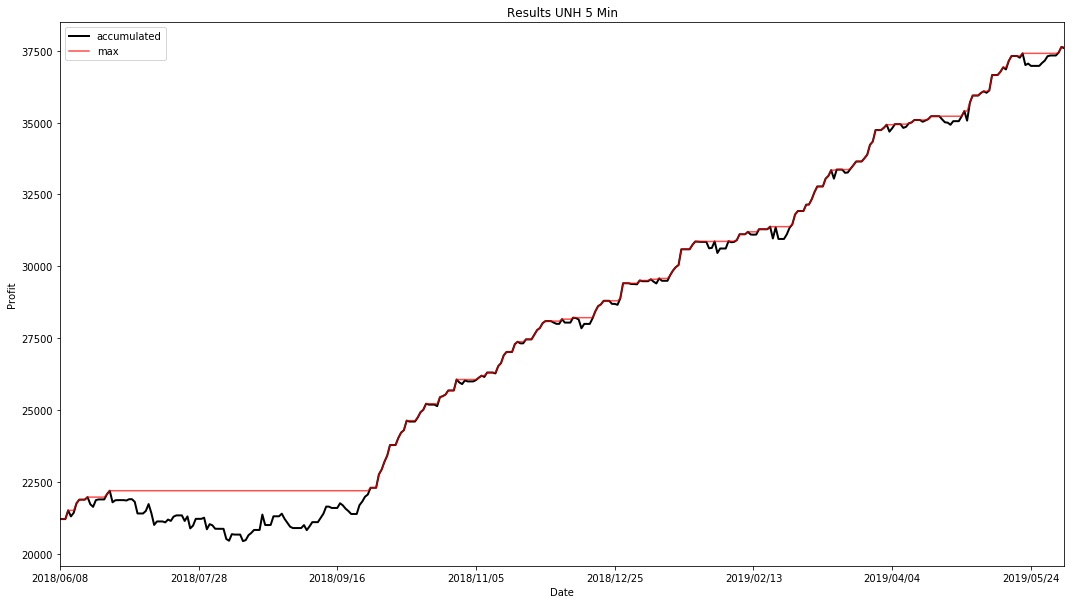

In [43]:
total['accumulated profit'].plot(figsize=(18,10),label='accumulated',color='black',lw=2)
total['max profit'].plot(color='red',label='max',ls='-',alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Profit')
plt.title('Results '+instrument+' '+str(tempo)+' Min')
plt.legend()
plt.savefig(instrument+'_'+str(tempo)+'Min.png')